<a href="https://colab.research.google.com/github/lbk209/topic_modeling/blob/main/tm_wine_reviews_cab6_02_emb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📄 **Data**

In [1]:
import os
import pandas as pd
import plotly.express as px
from tqdm import tqdm

## Import review data

from local

In [ ]:
from google.colab import files
uploaded = files.upload()

from google drive

In [ ]:
# use colab menu if possible
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
path_wr = 'sample_data'
file_wr_zip = 'wine_reviews_cab6.zip'
file_wr = 'wine_%s.csv'

file = f'/content/drive/MyDrive/Colab\ Notebooks/{file_wr_zip}'
!cp {file} .

In [3]:
!unzip {file_wr_zip} -d {path_wr}

Archive:  wine_reviews_cab6.zip
  inflating: sample_data/wine_0.csv  
  inflating: sample_data/wine_1.csv  
  inflating: sample_data/wine_2.csv  
  inflating: sample_data/wine_3.csv  
  inflating: sample_data/wine_4.csv  
  inflating: sample_data/wine_5.csv  


## Merge wines

In [ ]:
def find_files(directory, pattern):
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.startswith(pattern.split('%s')[0]) and filename.endswith(pattern.split('%s')[1]):
                files.append(os.path.join(root, filename))
    return sorted(files)


df_reviews = pd.DataFrame()

for f in find_files(path_wr, file_wr):
    df = pd.read_csv(f, parse_dates=['date'])
    df_reviews = pd.concat([df_reviews if not df_reviews.empty else None, df])
    #break

df_reviews = df_reviews.reset_index(drop=True)

df_reviews.head(5)

,id,wine,date,review
0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me
1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m..."
2,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-19,Aight
3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯
4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...


In [ ]:
df_reviews = df_reviews.rename(columns={"id": "wid"}).reset_index(names=['id'])
df_reviews.head(5)

,id,wid,wine,date,review
0,0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me
1,1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m..."
2,2,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-19,Aight
3,3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯
4,4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...


In [ ]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

2024.0     29
2023.0    627
2022.0    954
2021.0     59
2020.0      2
2019.0      1
2017.0      1
Name: date, dtype: int64

In [ ]:
df_reviews = df_reviews.loc[df_reviews.date.dt.year >= 2022]

In [ ]:
def plot_reviews_by_wine(df_reviews, col1='wine', col2='id',
                         title='Reviews for Wines',
                         ylabel='number of reviews'):

    colormap = px.colors.sequential.YlGnBu

    fig = px.bar(
        df_reviews.groupby(col1)[[col2]].count()\
            .sort_values(col2, ascending = False),
        text_auto = 'd',
        title = title,
        labels = {'value': ylabel},
        width=800
    )

    fig.update_traces(marker_color=colormap[6], marker_line_color=colormap[6],
                    marker_line_width=1.5, opacity=0.9)

    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

    fig.update_layout(showlegend = False)

    return fig


plot_reviews_by_wine(df_reviews)

## Translating comments

In [ ]:
!pip install langdetect deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 6.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=4f98b8bde4a21728d01cd251f9537cb6f3a51e057dcfbe804e87be883f32c1c9
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import langdetect
import json
from deep_translator import GoogleTranslator

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

In [ ]:
tmp_data = []

for rec in tqdm(df_reviews.to_dict('records')):
    tmp_data.append(
        {'id': rec['id'],
        'lang': detect_language(rec['review']),
        'review_transl': get_translation(rec['review'])}
    )

100%|██████████| 1610/1610 [15:56<00:00,  1.68it/s]


In [ ]:
df_reviews = df_reviews.merge(pd.DataFrame(tmp_data))
df_reviews.head()

,id,wid,wine,date,review,lang,review_transl
0,0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me,en,Little too cherry on the front end for me
1,1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m...",no,A small sharp crack in the taste. Ok Friday wi...
2,2,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-19,Aight,en,Aight
3,3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯,ko,Good taste and good value for money
4,4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...,en,oak cherry black cherry chocolate blackcurrant...


In [ ]:
path = 'sample_data'
file = 'wine_reviews_cab6_transl'

df_reviews.to_csv(f'{path}/{file}.csv', index = False)

In [ ]:
!zip -j {file}.zip {path}/{file}.csv

  adding: wine_reviews_cab6_transl.csv (deflated 69%)


In [ ]:
path = '/content/drive/MyDrive/Colab\ Notebooks/'
!cp {file}.zip {path}

#### Import saved

In [ ]:
path = 'sample_data'
file = 'wine_reviews_cab6_transl'

In [ ]:
!unzip {file}.zip -d {path}

Archive:  wine_reviews_cab6_transl.zip
replace sample_data/wine_reviews_cab6_transl.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
f = f'{path}/{file}.csv'
df_reviews = pd.read_csv(f, parse_dates=['date'])
df_reviews.head()

,id,wid,wine,date,review,lang,review_transl
0,0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me,en,Little too cherry on the front end for me
1,1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m...",no,A small sharp crack in the taste. Ok Friday wi...
2,2,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-19,Aight,en,Aight
3,3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯,ko,Good taste and good value for money
4,4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...,en,oak cherry black cherry chocolate blackcurrant...


## Clearing not meaningful comments

### Languages

In [ ]:
fig = px.bar(100*df_reviews.lang.value_counts(normalize = True).head(10), text_auto = '.2f',
    labels = {'value': 'share of reviews, %', 'index': 'language'},
    title = 'Top reviews languages',
            width=800)
colormap = px.colors.sequential.YlGnBu

fig.update_layout(showlegend = False)

fig.update_traces(marker_color=colormap[6], marker_line_color=colormap[6],
                  marker_line_width=1.5, opacity=0.9)

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

In [ ]:
#df_reviews.lang.value_counts()

cond = df_reviews.lang.str.contains('ERROR')
df_reviews.loc[cond].review.value_counts().head(10)

2020                      2
…… …. …… ……. …… …… …….    1
7,900                     1
👌🏻                        1
👍                         1
🥰                         1
🔝                         1
🥴                         1
😌                         1
@                         1
Name: review, dtype: int64

drop reviews of translation error

In [ ]:
df_reviews = df_reviews.loc[~cond]

### Length of review

In [ ]:
# strips any leading or trailing whitespace characters
df_reviews['review_transl'] = df_reviews['review_transl'].map(lambda x: str(x).strip())

df_reviews['review_len'] = df_reviews.review_transl.map(lambda x: len(x))
df_reviews.head()

,id,wid,wine,date,review,lang,review_transl,review_len
0,0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me,en,Little too cherry on the front end for me,41
1,1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m...",no,A small sharp crack in the taste. Ok Friday wi...,62
2,2,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-19,Aight,en,Aight,5
3,3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯,ko,Good taste and good value for money,35
4,4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...,en,oak cherry black cherry chocolate blackcurrant...,77


In [ ]:
fig = px.histogram(df_reviews, x="review_len",
                  nbins=250, range_x = [0, 500],
                  histnorm = 'percent',
                  labels = {'review_len': 'number of characters', 'percent': 'share of reviews, %'},
                  title = 'Number of characters in review',
                  width=800)

fig.update_traces(marker_color=colormap[6],
                  opacity=0.9)
fig

In [ ]:
fig = px.histogram(df_reviews, x="review_len", color = 'wine',
                  nbins=500,
                   #range_x = [0, 1000],
                  labels = {'review_len': 'number of characters', 'percent': 'share of reviews, %'},
                  title = 'Number of characters in review',
                  #width=800
                   )

fig

*We can look at the most common examples to see whether there’s not much information in such comments or not.*

In [ ]:
df_reviews.review_transl.map(lambda x: x.lower().strip()).value_counts().head(10)

very good     11
good           9
bom            7
tasty          5
great          5
bueno          4
good value     3
chocolate      3
delicious      3
ok             3
Name: review_transl, dtype: int64

In [ ]:
min_len = 10
cond = df_reviews.review_len < min_len

x = df_reviews[cond].shape[0],
y = df_reviews.shape[0]
z = df_reviews[cond].shape[0]/df_reviews.shape[0]

print(f'{x} / {y} = {z:.4f}')

(156,) / 1581 = 0.0987


we can filter out all comments shorter than x symbols — y out of z reviews (w%). Then, we will analyse only long statements with more context. It’s an arbitrary threshold based on examples, you can try a couple of levels and see what texts are filtered out.


In [ ]:
df_reviews['length_group'] = df_reviews.review_len.map(
    lambda x: f'<= {min_len}' if x < min_len else f'> {min_len}')

It’s worth checking whether this filter disproportionally affects some hotels. Shares of short comments are pretty close for different categories. So, the data looks OK.

In [ ]:
len_stats_df = df_reviews.pivot_table(index = 'wine', values = 'id',
              columns = 'length_group', aggfunc = 'count')

len_stats_df['total'] = len_stats_df.sum(axis = 1)
len_stats_df = len_stats_df.sort_values('total', ascending = False)
px.bar(
    len_stats_df.apply(lambda x: 100.*x/len_stats_df.total).drop('total', axis = 1),
    text_auto = '.2f',
    color_discrete_map = {
          '<= 20': colormap[2],
          '> 20': colormap[5]
      }, title = "Reviews' length by hotel",
    labels = {'value': 'share of reviews, %', 'course_id': 'course',
             'length_group': 'review length'},
    width=800
)

In [ ]:
#df_reviews2 = df_reviews[df_reviews.review_len > min_len].drop('length_group', axis = 1)
#df_reviews2.head()

In [ ]:
path = 'sample_data'
file = 'wine_reviews_cab6_transl2'

df_reviews.to_csv(f'{path}/{file}.csv', index = False)

In [ ]:
!zip -j {file}.zip {path}/{file}.csv

  adding: wine_reviews_cab6_transl2.csv (deflated 69%)


In [ ]:
path = '/content/drive/MyDrive/Colab\ Notebooks/'
!cp {file}.zip {path}

### Import saved

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
file = 'wine_reviews_cab6_transl2'
path = 'sample_data'
path_src = '/content/drive/MyDrive/Colab\ Notebooks/'

In [5]:
!unzip {path_src}/{file}.zip -d {path}

Archive:  /content/drive/MyDrive/Colab Notebooks//wine_reviews_cab6_transl2.zip
  inflating: sample_data/wine_reviews_cab6_transl2.csv  


In [6]:
import pandas as pd
f = f'{path}/{file}.csv'
df_reviews = pd.read_csv(f, parse_dates=['date'])
df_reviews.head()

,id,wid,wine,date,review,lang,review_transl,review_len,length_group
0,0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me,en,Little too cherry on the front end for me,41,> 10
1,1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m...",no,A small sharp crack in the taste. Ok Friday wi...,62,> 10
2,2,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-19,Aight,en,Aight,5,<= 10
3,3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯,ko,Good taste and good value for money,35,> 10
4,4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...,en,oak cherry black cherry chocolate blackcurrant...,77,> 10


## Create Docs

In [7]:
docs = df_reviews.review_transl.tolist()


# 🤗 HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [8]:
from huggingface_hub import notebook_login
notebook_login()

# 🗨️ **BERTopic**

In [10]:
# for cpu runtime
%%capture
!pip install bertopic accelerate adjustText

quantization_config = None

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:
#docs = df_data.reviews_transl.tolist()

In [40]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
#st_id = "BAAI/bge-small-en" # Recommend switching to newest BAAI/bge-small-en-v1.5
#st_id = 'BAAI/bge-small-en-v1.5'

#st_id = 'all-MiniLM-L6-v2' # mapping sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.
st_id = 'all-MiniLM-L12-v2'

embedding_model = SentenceTransformer(st_id)

embeddings = embedding_model.encode(docs, show_progress_bar=True)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [41]:
n_components = 15 # dimensionality
n_neighbors = 10

min_cluster_size = 10

top_n_words = 10 # top n words in combined documents in a cluster

n_components/len(docs)

0.009487666034155597

In [42]:
from umap import UMAP
from hdbscan import HDBSCAN

# dimensionality reduction
umap_model = UMAP(
    n_components=n_components,
    n_neighbors=n_neighbors,
    min_dist=0.0,
    metric='cosine', random_state=42)

# clustering algorithm
hdbscan_model = HDBSCAN(
    # a lower min_cluster_size will generate more topics
    min_cluster_size=min_cluster_size,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
    )

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [43]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)
llama2desc = TextGeneration(generator, prompt=prompt_desc)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "Llama2Desc": llama2desc,
    "MMR": mmr,
}

In [44]:
# for fast training to assess the number of topics
from bertopic.representation import KeyBERTInspired


representation_model = KeyBERTInspired()

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

## Custom utils

In [17]:
def get_llm_labels(topic_model, name, tid=None):
    try:
        #labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_[name].items()}
        labels = {topic: list(zip(*values))[0][0] for topic, values in topic_model.topic_aspects_[name].items()}
        labels[-1] = "Outlier Topic"
    except KeyError:
        print("ERROR: Must choose a llm name from aspects:")
        print(', '.join(topic_model.topic_aspects_.keys()))
        return None

    if tid is None:
        return labels
    else:
        try:
            return labels[tid]
        except KeyError:
            print("ERROR: Check the topic id")
            return None


def set_llm_labels(topic_model, name):
    labels = get_llm_labels(topic_model, name)
    topic_model.set_topic_labels(labels)
    return topic_model


#name = 'Llama2'
#tid = 0
#get_llm_labels(topic_model, name, tid)
#topic_model = set_llm_labels(topic_model, name)


def print_with_line_feed(input_string, line_length=50):
    words = input_string.split()
    current_line_length = 0

    for word in words:
        if current_line_length + len(word) <= line_length:
            print(word, end=" ")
            current_line_length += len(word) + 1  # +1 for the space
        else:
            print()  # Start a new line
            print(word, end=" ")
            current_line_length = len(word) + 1

    print()  # Ensure the last line is printed

# Example usage
#your_string = "This is a sample string that you want to print with line feed every 50 characters. This string is just for demonstration purposes."
#print_with_line_feed(your_string)


def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation'] + extra_cols]

#extra_cols = ['Llama2', 'Llama2Desc']
#get_topic_stats(topic_model, extra_cols).head(10).set_index('Topic')

## Generate BERTopic

In [45]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=top_n_words,
  verbose=True,

  # Calculate the probabilities of all topics per document instead of the probability of the assigned topic per document.
  # This could slow down the extraction of topics if you have many documents (> 100_000).
  calculate_probabilities=True
)

# Train model
topics, probs = topic_model.fit_transform(
    docs,
    embeddings # need embedding_model
    )

2024-01-29 03:51:35,661 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-29 03:51:43,719 - BERTopic - Dimensionality - Completed ✓
2024-01-29 03:51:43,721 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-29 03:51:43,932 - BERTopic - Cluster - Completed ✓
2024-01-29 03:51:43,942 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-29 03:51:52,183 - BERTopic - Representation - Completed ✓


In [46]:
len(topic_model.get_topics()) - 1

30

In [47]:
# Show topics
topic_model.get_topic_info().head(7)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,378,-1_flavor_strawberry_fruity_tannins,"[flavor, strawberry, fruity, tannins, taste, b...","[Yellow tail, this is my first time having it...."
1,0,508,0_wines_wine_sauvignon_bottle,"[wines, wine, sauvignon, bottle, aromas, alcoh...","[In addition to its beautiful dark red color, ..."
2,1,58,1_sour_flavour_bitter_taste,"[sour, flavour, bitter, taste, flavor, tasted,...","[Too sour, Very sour and bitter, not delicious..."
3,2,51,2_bad_very_good_best,"[bad, very, good, best, awful, nice, marvelous...","[Excellent, my favorite!! The best I've ever h..."
4,3,47,3_drink_drinkable_drinks_drinking,"[drink, drinkable, drinks, drinking, drinker, ...","[Cheap to drink, easy to drink and cheap!, Goo..."
5,4,46,4_value_worths_price_money,"[value, worths, price, money, dollar, decent, ...","[Good value for money, Good value for money, G..."
6,5,45,5_oak_cherry_chocolate_blackcurrant,"[oak, cherry, chocolate, blackcurrant, oaky, b...","[cherry oak, oak black cherry plum chocolate v..."


In [48]:
titles = [x[:100] for x in docs]
topics_to_visualize = range(20)

topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, hide_document_hover=False,
                                topics=topics_to_visualize,
                                #custom_labels=True
                                )

In [49]:
# set `calculate_probabilities` to True as it uses the topic probabilities of all topics
topic_model.visualize_distribution(probs[0])

## Save model

In [52]:
#file = 'tm_wine_reviews_cab6_emb1'
file = 'tm_wine_reviews_cab6_emb2'
path = 'sample_data'

In [53]:
#x = "sentence-transformers/all-MiniLM-L6-v2"
x = "sentence-transformers/all-MiniLM-L12-v2"
file_model = f'{path}/{file}'

topic_model.save(file_model, serialization="safetensors", save_embedding_model=x, save_ctfidf=True)

In [54]:
import pickle

#Store sentences & embeddings on disc
file_attrs = f'{path}/{file}_attrs.pkl'

with open(file_attrs, "wb") as fOut:
    obj = {'reduced_embeddings': reduced_embeddings,
           'representative_docs_': topic_model.representative_docs_,
           'embedding model': f'{st_id}'
           }
    pickle.dump(obj, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

zfile = f'/content/drive/MyDrive/Colab\ Notebooks/{file}.zip'
!zip -r {zfile} {file_model} {file_attrs}

  adding: sample_data/tm_wine_reviews_cab6_emb2/ (stored 0%)
  adding: sample_data/tm_wine_reviews_cab6_emb2/ctfidf.safetensors (deflated 65%)
  adding: sample_data/tm_wine_reviews_cab6_emb2/config.json (deflated 41%)
  adding: sample_data/tm_wine_reviews_cab6_emb2/topic_embeddings.safetensors (deflated 7%)
  adding: sample_data/tm_wine_reviews_cab6_emb2/ctfidf_config.json (deflated 68%)
  adding: sample_data/tm_wine_reviews_cab6_emb2/topics.json (deflated 79%)
  adding: sample_data/tm_wine_reviews_cab6_emb2_attrs.pkl (deflated 20%)


## Load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [69]:
model1 = 'tm_wine_reviews_cab6_emb1'
file = f'{model1}.zip'
f = f'/content/drive/MyDrive/Colab\ Notebooks/{file}'
!cp {f} .

In [35]:
!unzip {file}

Archive:  tm_wine_reviews_cab6_emb1.zip
replace sample_data/tm_wine_reviews_cab6_emb1/ctfidf.safetensors? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [70]:
model2 = 'tm_wine_reviews_cab6_emb2'
file = f'{model2}.zip'
f = f'/content/drive/MyDrive/Colab\ Notebooks/{file}'
!cp {f} .

In [ ]:
!unzip {file}

Archive:  tm_wine_reviews_cab6_emb1.zip
replace sample_data/tm_wine_reviews_cab6_emb1/ctfidf.safetensors? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%%capture
!pip install bertopic

In [75]:
from bertopic import BERTopic
import pickle

def load_topic_model(name, path = 'sample_data'):
    d = f'{path}/{name}'
    topic_model = BERTopic.load(d)

    #Load sentences & embeddings from disc
    f = f'{path}/{name}_attrs.pkl'

    with open(f, "rb") as fIn:
        obj = pickle.load(fIn)
        reduced_embeddings = obj['reduced_embeddings']
        topic_model.representative_docs_ = obj['representative_docs_']

    x = 'embedding model'
    print(f'{x}: {obj[x]}')

    return topic_model

In [76]:
topic_model1 = load_topic_model(model1)
topic_model2 = load_topic_model(model2)


embedding model: all-MiniLM-L12-v2
embedding model: all-MiniLM-L12-v2


Run [Custom utils](#scrollTo=rp6ExMwAkmfv&line=1&uniqifier=1) first

In [ ]:
#topic_model = set_llm_labels(topic_model, 'Llama2')

In [39]:
custom_labels = False
topics_to_visualize = range(20)

titles = [x[:100] for x in docs]
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, hide_document_hover=False,
                                topics=topics_to_visualize,
                                custom_labels=custom_labels,
                                #width=600,
                                #height=600
                                )

In [ ]:
l = topic_model.custom_labels_
_ = [print(f'{i}: {x}') for i, x in enumerate(l) if 'K-pop' in x]

12: K-pop fan culture


In [ ]:
df = topic_model.get_topic_info()
df.loc[df.CustomName == l[12]]

,Topic,Count,Name,CustomName,Representation,KeyBERT,Llama2,Llama2Desc,MMR,Representative_Docs
12,11,34,11_bom_bueno_20240116_jeongmin,K-pop fan culture,"[bom, bueno, 20240116, jeongmin, benest, bolog...","[bom, bolognes, ba, bueno, brie, buchko, , , , ]","[K-pop fan culture, , , , , , , , , ]",[The topic appears to be related to various me...,"[bom, bueno, 20240116, jeongmin, benest, bolog...","[Bom, Bom, Bom]"


In [ ]:
# need to train llm to understand wine and food pairngs
[y for x, y in zip(topic_model.topics_, docs) if x==11]

['@Bukchon',
 'earthy @',
 'Bom',
 'Dongwon Benest',
 'Bom',
 'Deliciaaaa!',
 'bueno',
 'Nono',
 '20240116 Brie, chorizo \u200b\u200bsausage 49',
 'Bueno',
 'Bom.',
 '@Dawn Buchko',
 'H h',
 '@itsuda',
 'Bom',
 'Mt bom!',
 'Full and good ba de scheup me frut from moama (LG)',
 'Oui',
 'Nomnomnom',
 'Good match with spagetti bolognes 🍝🍝',
 'Bom',
 'Bueno',
 'WSET Diploma D2 training.',
 '@Jeongmin',
 'Bom',
 'Bom',
 'Miau',
 '@Naira Ravanny',
 'Course meeting!',
 '4,45eur',
 'D',
 'Bueno',
 'Ixiii',
 'Bom']

# 💦 **Post-processing**

## Vectorizer
Pass the CountVectorizer after training where llm used full context in training => ???

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Fine-tune topic representations after training BERTopic
# you can pass the CountVectorizer before and after training your topic model.
# Passing it before training allows you to minimize the size of the resulting c-TF-IDF matrix
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3),
                                   #min_df=10
                                   )
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [ ]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name,CustomName,Representation,KeyBERT,Llama2,Llama2Desc,MMR,Representative_Docs
0,-1,496,-1_wine_good_red_taste,Outlier Topic,"[wine, good, red, taste, dry, price, chocolate...","[wine, scent, taste, flavor, acidity, oak, ple...","[Wine Reviews, , , , , , , , , ]","[Discounted yet high-quality wine options, , ,...","[it, wine, the, and, for, is, of, to, with, but]",[Quite surprising! For the price this is a gre...
1,0,126,0_wine_oak_red_dark,Wine Review,"[wine, oak, red, dark, fruit, tannins, red win...","[wines, wine, tannins, aromas, sweetness, tann...","[Wine Review, , , , , , , , , ]",[A rich and complex red wine with notes of dar...,"[wine, oak, and, red, of, the, with, dark, fru...","[Honest wine for the price found, cork stopper..."
2,1,115,1_oak_cherry_blackberry_chocolate,Flavor profiles,"[oak, cherry, blackberry, chocolate, vanilla, ...","[blackberries, berries, cherry, strawberry, ch...","[Flavor profiles, , , , , , , , , ]",[Flavor profiles and pairings involving variou...,"[oak, cherry, blackberry, chocolate, vanilla, ...",[chocolate vanilla oak blackberry blackcurrant...
3,2,74,2_cabernet_sauvignon_cabernet sauvignon_medium,Wine Reviews,"[cabernet, sauvignon, cabernet sauvignon, medi...","[sauvignon, wines, cabernet, wine, grape, cab,...","[Wine Reviews, , , , , , , , , ]","[Cabernet Sauvignon wine review, , , , , , , ,...","[cabernet, sauvignon, with, and, of, this, in,...","[Good tasting Cabernet Sauvignon., This Chilea..."
4,3,71,3_value_money_value money_good,Value for Money,"[value, money, value money, good, good value, ...","[value, worth, money, profitably, worths, doll...","[Value for Money, , , , , , , , , ]",[The topic is about finding good value for mon...,"[value, money, cost, for, price, good, excelle...","[Good value for money, Good value for money, G..."
5,4,71,4_fruity_fruity good_good_strawberry,Fruit flavors,"[fruity, fruity good, good, strawberry, fruity...","[fruity, fruits, strawberry, berries, flavor, ...","[Fruit flavors, , , , , , , , , ]","[Flavor profile of fruity drinks, , , , , , , ...","[fruity, and, with, strawberry, good, very, no...","[Fruity, good to taste, Fruity, Fruity]"
6,5,50,5_ruby_medium_color_red,"Wine Label: ""Fruit-Forward Red""","[ruby, medium, color, red, ruby color, body, r...","[fruits, fruit, strawberry, blueberries, sweet...","[Wine Label: ""Fruit-Forward Red"", , , , , , , ...","[Wine descriptions, , , , , , , , , ]","[ruby, medium, color, red, body, and, with, fr...","[Intense ruby ​​color, aroma of red fruits and..."
7,6,47,6_chilean_chilean wine_chile_wine,Chilean Wine,"[chilean, chilean wine, chile, wine, good chil...","[chilean, chile, cabernet, wines, wine, grape,...","[Chilean Wine, , , , , , , , , ]",[Chilean wine varieties and blind taste testin...,"[chilean, chile, the, from, in, of, wine, is, ...","[Very good Chilean Cabernet!, Chilean, Chilean..."
8,7,41,7_sour_bitter_bitterness_sweet,Taste profile,"[sour, bitter, bitterness, sweet, bit sour, af...","[sour, sourness, flavor, tasted, bitter, taste...","[Taste profile, , , , , , , , , ]",[The topic of sour and bitter tastes in food a...,"[sour, bitter, bitterness, sweet, not, afterta...","[Light sour, Too sour, Very sour and bitter, n..."
9,8,38,8_wine_wine wine_cheap wine_everyday,Everyday Wine,"[wine, wine wine, cheap wine, everyday, simple...","[wine, booze, drink, cola, corked, coca, every...","[Everyday Wine, , , , , , , , , ]","[Everyday simplicity in affordable wine, , , ,...","[wine, everyday, simple, cheap, gave, life, th...","[Someone else gave it to my father-in-law, who..."


In [ ]:
num = 5
line_length = 100
cols = ['Topic', 'Count', 'Llama2', 'Llama2Desc']

for _, r in topic_model.get_topic_info().loc[1:, cols].head(num).iterrows():
    print(f'Topic {r[0]}, Count {r[1]}: {r[2][0]}')
    print_with_line_feed(r[3][0], line_length)
    #print('-'*line_length)
    print()

Topic 0, Count 126: Wine Review
A rich and complex red wine with notes of dark fruit, oak, and spice, displaying a medium body and 
moderate tannins, showing a subtle imbalance towards dryness on the palate. 

Topic 1, Count 115: Flavor profiles
Flavor profiles and pairings involving various fruits, spices, and other ingredients. 

Topic 2, Count 74: Wine Reviews
Cabernet Sauvignon wine review 

Topic 3, Count 71: Value for Money
The topic is about finding good value for money or getting the best bang for your buck. 

Topic 4, Count 71: Fruit flavors
Flavor profile of fruity drinks 



## Outlier reduction

In [ ]:
# Use the "c-TF-IDF" strategy with a threshold
# threshold is the minimum similarity.
new_topics = topic_model.reduce_outliers(docs, topics , strategy="c-tf-idf", threshold=0.1)

# count outliers
len([x for x in new_topics if x < 0])

6455

In [ ]:
t = topics
#t = new_topics

new_topics = topic_model.reduce_outliers(docs, t , strategy="distributions", threshold=0.5)

# count outliers
len([x for x in new_topics if x < 0])

100%|██████████| 7/7 [00:22<00:00,  3.25s/it]


6231

In [ ]:
t = topics
#t = new_topics
new_topics = topic_model.reduce_outliers(docs, t, strategy="embeddings", threshold=0.5)

# count outliers
len([x for x in new_topics if x < 0])

1988

In [ ]:
t = topics
#t = new_topics

# the threshold is minimum probability when strategy="probabilities"
new_topics = topic_model.reduce_outliers(docs, t, strategy="probabilities", probabilities=probs, threshold=0.05)

# count outliers
len([x for x in new_topics if x < 0])

6678

### update with new_topics

In [ ]:
topic_model.update_topics(docs, topics=new_topics)

2024-01-22 01:08:32,468 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
titles = [x[:100] for x in docs]
topics_to_visualize = range(20)

topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, hide_document_hover=False,
                                topics=topics_to_visualize,
                                #custom_labels=True
                                )

Now that we are done training our model, let's see what topics were generated:

In [ ]:
extra_cols = ['Llama2', 'Llama2Desc']
#extra_cols = []
get_topic_stats(topic_model, extra_cols).head(10).set_index('Topic')

,Count,Share,CumulativeShare,Name,Representation,Llama2,Llama2Desc
Topic,,,,,,,
-1,7227,58.775211,58.775211,-1_hotel_room_good_london,"[hotel, room, good, london, breakfast, staff, ...","[Travelodge, , , , , , , , , ]","[Travelodge hotels, specifically those located..."
0,541,4.399805,63.175016,0_hotel_great_good_location,"[hotel, great, good, location, staff, stay, ni...","[Central London Hotels, , , , , , , , , ]",[This topic revolves around positive reviews o...
1,359,2.919649,66.094665,1_london_hotel_great_location,"[london, hotel, great, location, stay, good, s...","[London Hotel Review, , , , , , , , , ]",[A luxurious and conveniently located hotel of...
2,284,2.309694,68.404359,2_victoria_plaza_victoria station_park plaza,"[victoria, plaza, victoria station, park plaza...","[Hotel Review, , , , , , , , , ]",[Stays at the Victoria Park Plaza Hotel in Lon...
3,230,1.870527,70.274886,3_paddington_heathrow_station_paddington station,"[paddington, heathrow, station, paddington sta...","[Convenient Hotels Near Paddington Station, , ...","[Conveniently located near Paddington Station,..."
4,225,1.829863,72.104750,4_gloucester_hotel_room_tube,"[gloucester, hotel, room, tube, gloucester roa...","[Hotel Location, , , , , , , , , ]",[Stayed at the Millennium Gloucester hotel in ...
5,193,1.569616,73.674366,5_noise_room_noisy_hotel,"[noise, room, noisy, hotel, night, sleep, floo...","[Noisy Hotel Experience, , , , , , , , , ]","[Noisy environment with various distractions, ..."
6,191,1.553351,75.227716,6_radisson_hotel_edwardian_radisson edwardian,"[radisson, hotel, edwardian, radisson edwardia...","[Radisson Hotels, , , , , , , , , ]",[Staying at the Radisson Edwardian hotels in L...
7,162,1.317502,76.545218,7_hilton_london_hotel_bridge,"[hilton, london, hotel, bridge, room, tower, g...","[Modern Hotel in London, , , , , , , , , ]",[Stays at the Hilton London Tower Bridge hotel...


In [ ]:
topic_model.custom_labels_[:7]

['Positive Hotel Review',
 'Hotel Reviews',
 'Convenient location for Heathrow travel',
 'Great London Hotel Experience',
 'Millennium Gloucester Hotel',
 'Modern Hotel near London Tower',
 'Hotel Near Oxford Street']

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [ ]:
custom_labels = True

In [ ]:
titles = [x[:100] for x in docs]
topics_to_visualize = range(20)

topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
                                topics=topics_to_visualize,
                                hide_annotations=True, hide_document_hover=False, custom_labels=custom_labels)

In [ ]:
topic_model.visualize_barchart(top_n_topics = 8,
                               n_words = 10,
                               custom_labels=custom_labels,
                               height=300)

In [ ]:
topic_model.visualize_topics(custom_labels=custom_labels)

In [ ]:
topic_model.visualize_heatmap(
    n_clusters = 20,
    custom_labels=custom_labels
    )

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))

dist_df = pd.DataFrame(distance_matrix, columns=topic_model.topic_labels_.values(),
                       index=topic_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index':
            continue
        tmp.append(
            {
                'topic1': t1,
                'topic2': t2,
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(lambda x: not x.startswith('-1'))) &
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]

pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]

In [ ]:
pair_dist_df.sort_values('distance', ascending = False).head(10)

,topic1,topic2,distance
345,10_wine_value_price_money,3_value_money_value money_good,0.923498
459,13_good good_good_good good good_bad good,24_good good_good good good_good_good feel,0.920948
567,17_wine_wine good wine_good wine_wine great,8_wine_wine wine_cheap wine_everyday,0.883239
369,10_wine_value_price_money,27_price_taste_taste price_price taste,0.838357
33,0_wine_oak_red_dark,1_oak_cherry_blackberry_chocolate,0.837084
872,27_price_taste_taste price_price taste,3_value_money_value money_good,0.832168
58,0_wine_oak_red_dark,26_wine_wine bit_second_alcohol,0.818197
553,16_aroma_smoky_intense_nose,25_flavor_taste_light_rich,0.806710
50,0_wine_oak_red_dark,18_tannins_tannin_light_medium,0.781053
846,26_wine_wine bit_second_alcohol,8_wine_wine wine_cheap wine_everyday,0.775453


# Topic Distributions
If using calculate_probabilities=True is not possible, then you can approximate the topic-document distributions using .approximate_distribution. It is a fast and flexible method for creating different topic-document distributions.

In [ ]:
# If using calculate_probabilities=True
#topic_distr = probs

# If using calculate_probabilities=True is not possible
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, window = 4, calculate_tokens=True)

100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


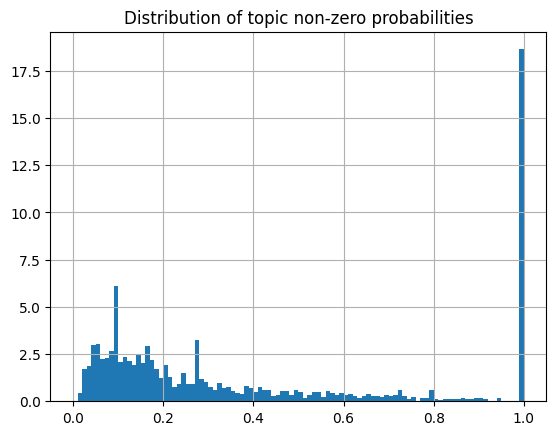

In [ ]:
import numpy as np

raw_distr = pd.Series(topic_distr.ravel())
raw_distr = raw_distr[raw_distr > 0]

ax = raw_distr.hist(bins = 100, range = [0, 1],
                                        weights = np.ones_like(raw_distr)*100/raw_distr.shape[0])
_ = ax.set_title('Distribution of topic non-zero probabilities')

In [ ]:
threshold = 0.05

df_reviews['max_topic_distr'] = topic_distr.max(axis = 1)
1 - df_reviews[df_reviews.max_topic_distr > threshold].shape[0]/df_reviews.shape[0]

NameError: name 'df_data' is not defined

In [ ]:
df = df_reviews.reset_index(drop=True)
df_reviews[(df_reviews.max_topic_distr > threshold) & (df_reviews.reviews_len <= 100)].sample(10)

,id,hotel,review,lang,reviews_transl,reviews_len,max_topic_distr
579,594,Park Plaza,Park plaza victoria:londra non è stata mai cos...,it,Park Plaza Victoria: London has never been so ...,53,0.289048
5947,6217,Holiday Inn,Holiday Inn Bloomsbury Experiences.,en,Holiday Inn Bloomsbury Experiences.,35,1.000000
7302,7633,Holiday Inn,La mejor definición:Correcto.,es,Best definition: Correct.,25,1.000000
9423,9858,Millemiun,Muy buen hotel y muy bien situado.,es,Very good hotel and very well located.,38,0.149862
9014,9435,Holiday Inn,Fantastic Location - hard to beat!.,en,Fantastic Location - hard to beat!.,35,1.000000
5744,6002,Radisson,Loved the Radisson Edwardian.,en,Loved the Radisson Edwardian.,29,1.000000
8502,8878,Hilton,Good Location but Average Customer Service.,en,Good Location but Average Customer Service.,43,0.510096
1341,1386,Holiday Inn,Great location great service rock stars...the ...,en,Great location great service rock stars...the ...,53,0.570737
566,574,Park Plaza,Buena localización. Cómodo sin lujos. Buen des...,es,Good location. Comfortable without frills. Goo...,58,0.516786
6586,6885,Hilton,I hope all the UK hotels are at least this nice.,en,I hope all the UK hotels are at least this nice.,48,0.551375


In [ ]:
doc_id = 100
topic_distr[3].max()

0.419629345264902

In [ ]:
x = 0.05
topic_model.visualize_distribution(topic_distr[doc_id], min_probability=x, custom_labels=True)

In [ ]:
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])

,Dark,in,colour,some,oak,on,the,pallet,Dark,fruit
0_wine_oak_red_dark,0.000,0.000,0.000,0.177,0.177,0.177,0.177,0.000,0.000,0.000
1_oak_cherry_blackberry_chocolate,0.000,0.000,0.000,0.332,0.332,0.332,0.332,0.000,0.000,0.000


In [ ]:
import tqdm

tmp_dfs = []

for thr in tqdm.tqdm(np.arange(0, 0.15, 0.001)):
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1

    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')

    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr

    tmp_dfs.append(tmp_df_aggr)

100%|██████████| 150/150 [00:02<00:00, 71.35it/s]


In [ ]:
num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

In [ ]:
num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

In [ ]:
import plotly.express as px

colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df,
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      },
        width = 800
       )

## Topics per Class
use topics_per_class method

In [ ]:
classes = df_reviews.wine.tolist()

In [ ]:
topics_per_class = topic_model.topics_per_class(docs, classes=classes)

6it [00:00, 23.67it/s]


In [ ]:
normalize_frequency = False
custom_labels = True

In [ ]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10,
                                       normalize_frequency = normalize_frequency,
                                       width=1000, height=500,
                                       custom_labels=custom_labels)

### Share of reviews

In [ ]:
total_freq = df_reviews.groupby('wine').count().id.to_dict() # num of documents per class

df = topics_per_class.assign(Frequency=topics_per_class.apply(lambda x: x.Frequency/total_freq[x.Class], axis=1))

sum([v for k,v in total_freq.items()]), len(docs)

(1581, 1581)

In [ ]:
normalize_frequency = False
custom_labels = False

In [ ]:
topic_model.visualize_topics_per_class(df, top_n_topics=10,
                                       normalize_frequency = normalize_frequency,
                                       width=1000, height=500,
                                       custom_labels=custom_labels)

In [ ]:
for tid in range(10):

    l1 = get_llm_labels(topic_model, 'Llama2', tid)
    l2 = get_llm_labels(topic_model, 'Llama2Desc', tid)
    print_with_line_feed(f'{tid}. {l1}: {l2}', 80)


0. Wine Review: A rich and complex red wine with notes of dark fruit, oak, and 
spice, displaying a medium body and moderate tannins, showing a subtle imbalance 
towards dryness on the palate. 
1. Flavor profiles: Flavor profiles and pairings involving various fruits, 
spices, and other ingredients. 
2. Wine Reviews: Cabernet Sauvignon wine review 
3. Value for Money: The topic is about finding good value for money or getting 
the best bang for your buck. 
4. Fruit flavors: Flavor profile of fruity drinks 
5. Wine Label: "Fruit-Forward Red": Wine descriptions 
6. Chilean Wine: Chilean wine varieties and blind taste testing 
7. Taste profile: The topic of sour and bitter tastes in food and drinks, 
including descriptions of different levels of intensity and individual 
preferences. 
8. Everyday Wine: Everyday simplicity in affordable wine 
9. Affordable and enjoyable beverages: Affordable and convenient drink option 


In [ ]:
#get_llm_labels(topic_model, None)

tid = 2

l = get_llm_labels(topic_model, 'Llama2', tid)
print_with_line_feed(f'{l}:', 80)

l = get_llm_labels(topic_model, 'Llama2Desc', tid)
print_with_line_feed(l, 80)

Wine Reviews: 
Cabernet Sauvignon wine review 


In [ ]:
# for checking

tid = 1
hotel = 'Park Inn'

topics_per_class.loc[(topics_per_class.Topic==tid) & (topics_per_class.Class==hotel)].Frequency / total_freq[hotel]

34    0.023483
Name: Frequency, dtype: float64